In [1050]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# 1. Import Cleaned Data

In [1051]:
data = pd.read_csv('cleaned_data.csv',index_col=0)
cleaned_data = data

In [1052]:
# a reminder to see what data types we're working with (taken from data cleaning notebook)
continuous = ['price','sqft_living','sqft_lot','sqft_above','sqft_basement','lat','long','sqft_living15',
              'sqft_lot15']
discrete = ['id','bedrooms','bathrooms','floors','view','yr_built']
categorical = ['waterfront','condition','grade','zipcode','quarter_sold','year_sold']

In [1053]:
# NO IDEA WHY THE CATEGORIES WERE NOT PROCESSED FROM DATA CLEANING NOTEBOOK
# convert columns in categorical to category data type
for col in categorical:
    data[col] = data[col].astype('category')

In [1054]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19087 entries, 0 to 19086
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   id             19087 non-null  int64   
 1   price          19087 non-null  float64 
 2   bedrooms       19087 non-null  int64   
 3   bathrooms      19087 non-null  float64 
 4   sqft_living    19087 non-null  int64   
 5   sqft_lot       19087 non-null  int64   
 6   floors         19087 non-null  float64 
 7   waterfront     19087 non-null  category
 8   view           19087 non-null  float64 
 9   condition      19087 non-null  category
 10  grade          19087 non-null  category
 11  sqft_above     19087 non-null  int64   
 12  sqft_basement  19087 non-null  float64 
 13  yr_built       19087 non-null  int64   
 14  yr_renovated   19087 non-null  float64 
 15  zipcode        19087 non-null  category
 16  lat            19087 non-null  float64 
 17  long           19087 non-null  

In [1055]:
data.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,quarter_sold,year_sold
0,6414100192,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,...,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,4,2014
1,5631500400,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,...,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062,1,2015
2,2487200875,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,...,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,4,2014
3,1954400510,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,...,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,1,2015
4,7237550310,1230000.0,4,4.50,5420,101930,1.0,0.0,0.0,3,...,1530.0,2001,0.0,98053,47.6561,-122.005,4760,101930,2,2014


# 2. Binning Categorical Data

To deal with categorical data and the amount of levels it can produce, I decided to reduce the amount of levels by combining the levels of the categorical variables. This will reduce the number of levels and potentially improve the model performance as well.

I binned the following:
* Grade

## Grade

Grade is a continuous variable and it's better to reduce the number of categorical values. I decided to bin the grade to 4 different groups: 0-5 (poor), 5-8 (fair), 8-11 (good), 11-13(high) and drop the grade column.

In [1056]:
data['grade'].unique()

[7, 6, 8, 11, 9, ..., 10, 12, 4, 3, 13]
Length: 11
Categories (11, int64): [7, 6, 8, 11, ..., 12, 4, 3, 13]

In [1057]:
# bin each category
# 0 - 5 (poor)
# 5 - 8 (fair)
# 8 - 11 (good)
# 11 - 13 (high)
data['grade_binned'] = pd.cut(data['grade'],[0,5,8,11,13],labels=['Poor','Fair','Good','High'])

In [1058]:
pd.concat([data['grade_binned'].value_counts(dropna=False),
           round((data['grade_binned'].value_counts(dropna=False,normalize=True) * 100),2).rename("%")],axis=1)                

,grade_binned,%
Fair,15078,79.00
Good,3682,19.29
Poor,233,1.22
High,94,0.49


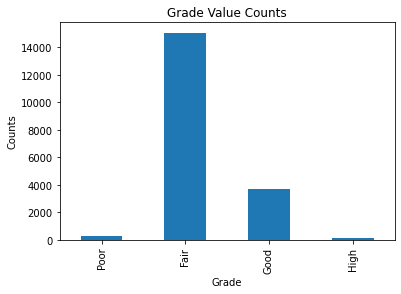

In [1059]:
# display bar graph with the grade binned values and their counts
data['grade_binned'].value_counts().loc[['Poor','Fair','Good','High']].plot(kind='bar').set_title('Grade Value Counts')
plt.xlabel('Grade')
plt.ylabel('Counts')
plt.show()

# 3. Feature Engineering

In addition to month_sold, year_sold, decade, and city we want to add new features to further increase the model.
* **total_sqft**: sqft_living + sqft_lot
* **total_sqft_inside**: sqft_above + sqft_basement
* **age_when_sold**: yr_sold - yr_built
* **age_after_renovated**: year_sold - yr_renovated
* **city**: location of the house based on zipcode
* **decade_built**: decade of when the house was built

## Total Square Feet

Description: Total square feet of all property, house and lot

In [1060]:
# create total_sqft column
data['total_sqft'] = data['sqft_living'] + data['sqft_lot']

total_sqft_values = data['total_sqft'].count()
total_sqft_nunique = data['total_sqft'].nunique()
total_sqft_missing_values = data['total_sqft'].isna().sum()

print(f'Number of values: {total_sqft_values}')
print(f'Number of unique values: {total_sqft_nunique}')
print(f'Missing values: {total_sqft_missing_values}')

Number of values: 19087
Number of unique values: 10322
Missing values: 0


## Total Square Feet Inside

Description: Total square feet of only the house

In [1061]:
# create total_sqft_inside column
data['total_sqft_inside'] = data['sqft_above'] + data['sqft_basement']

total_sqft_inside_values = data['total_sqft_inside'].count()
total_sqft_inside_nunique = data['total_sqft_inside'].nunique()
total_sqft_inside_missing_values = data['total_sqft_inside'].isna().sum()

print(f'Number of values: {total_sqft_inside_values}')
print(f'Number of unique values: {total_sqft_inside_nunique}')
print(f'Missing values: {total_sqft_inside_missing_values}')

Number of values: 19087
Number of unique values: 990
Missing values: 0


In [1062]:
pd.concat([data['total_sqft_inside'].value_counts(dropna=False),
           round((data['total_sqft_inside'].value_counts(dropna=False,normalize=True) * 100),2).rename("%")],axis=1)

,total_sqft_inside,%
1300.0,125,0.65
1400.0,121,0.63
1440.0,120,0.63
1820.0,116,0.61
1320.0,113,0.59
...,...,...
3135.0,1,0.01
1767.0,1,0.01
1315.0,1,0.01
2253.0,1,0.01


### Age When Sold

Description: the age of the house when it was sold, year_sold - yr_built

In [1063]:
# converting column to int to do calculation
data['year_sold'] = data['year_sold'].astype('int')

data['age_when_sold'] = data['year_sold'] - data['yr_built']

age_when_sold_values = data['age_when_sold'].count()
age_when_sold_nunique = data['age_when_sold'].nunique()
age_when_sold_missing_values = data['age_when_sold'].isna().sum()

print(f'Number of values: {age_when_sold_values}')
print(f'Number of unique values: {age_when_sold_nunique}')
print(f'Missing values: {age_when_sold_missing_values}')

## converting column back to 
data['year_sold'] = data['year_sold'].astype('category')

Number of values: 19087
Number of unique values: 117
Missing values: 0


In [1064]:
pd.concat([data['age_when_sold'].value_counts(dropna=False),
           round((data['age_when_sold'].value_counts(dropna=False,normalize=True) * 100),2).rename("%")],axis=1)

,age_when_sold,%
9,423,2.22
0,388,2.03
8,383,2.01
11,375,1.96
10,367,1.92
...,...,...
113,26,0.14
115,20,0.10
81,19,0.10
80,18,0.09


### Age After Renovated

Description: age of the house after it was renovated, yr_sold - yr_renovated

In [1065]:
# converting column to int to do calculation
data['year_sold'] = data['year_sold'].astype('int')

data['age_after_renovated'] = data['year_sold'] - data['yr_renovated']

age_after_renovated_values = data['age_after_renovated'].count()
age_after_renovated_nunique = data['age_after_renovated'].nunique()
age_after_renovated_missing_values = data['age_after_renovated'].isna().sum()

print(f'Number of values: {age_after_renovated_values}')
print(f'Number of unique values: {age_after_renovated_nunique}')
print(f'Missing values: {age_after_renovated_missing_values}')

## converting column back to 
data['year_sold'] = data['year_sold'].astype('category')

Number of values: 19087
Number of unique values: 70
Missing values: 0


In [1066]:
pd.concat([data['age_after_renovated'].value_counts(dropna=False),
           round((data['age_after_renovated'].value_counts(dropna=False,normalize=True) * 100),2).rename("%")],axis=1)

,age_after_renovated,%
2014.0,12428,65.11
2015.0,6009,31.48
0.0,62,0.32
1.0,32,0.17
8.0,28,0.15
...,...,...
57.0,1,0.01
65.0,1,0.01
60.0,1,0.01
80.0,1,0.01


In [1067]:
data['age_after_renovated'].describe()

count    19087.000000
mean      1946.347776
std        362.062271
min         -1.000000
25%       2014.000000
50%       2014.000000
75%       2015.000000
max       2015.000000
Name: age_after_renovated, dtype: float64

In [1068]:
# because year renovated has a lot of zero values meaning houses were not renovated, i was getting 2014 and 2015
# values which doesn't make sense. I converted the 2014 and 2015 values to -1 which will mean they were not renovated
data['age_after_renovated'] = data['age_after_renovated'].replace(2014,-1).replace(2015,-1)

In [1069]:
pd.concat([data['age_after_renovated'].value_counts(dropna=False),
           round((data['age_after_renovated'].value_counts(dropna=False,normalize=True) * 100),2).rename("%")],axis=1)

,age_after_renovated,%
-1.0,18443,96.63
0.0,62,0.32
1.0,32,0.17
8.0,28,0.15
10.0,26,0.14
...,...,...
64.0,1,0.01
66.0,1,0.01
61.0,1,0.01
57.0,1,0.01


### City

There are many unique values for zipcodes in which I decided to combine the zip codes by their city. I didn't have the zip code data for King County so I had to web scrape from zip-codes.com website to get the zip code and the respective city.

In [1070]:
from bs4 import BeautifulSoup
import requests

url = 'https://www.zip-codes.com/county/wa-king.asp#zipcodes'
page = requests.get(url)
soup = BeautifulSoup(page.content,'html.parser')
tb = soup.find('table',class_='statTable')

list_zip_codes = []
for link in tb.find_all('td'):
    zip_code = link.find('a')
    if zip_code is None:
        continue
    list_zip_codes.append(zip_code.get_text('title'))

zip_code_df = pd.concat([pd.Series([list_zip_codes[i][-5:] for i in range(0,len(list_zip_codes),2)]).astype('int64'),
                         pd.Series([list_zip_codes[i] for i in range(1,len(list_zip_codes),2)])],axis=1).rename(columns={0:'zipcode',1:'city'})
zip_code_df.head()

,zipcode,city
0,98001,Auburn
1,98002,Auburn
2,98003,Federal Way
3,98004,Bellevue
4,98005,Bellevue


In [1071]:
data = pd.merge(data,zip_code_df,on='zipcode',how='inner')
# data['city'] = data['city'].astype('category')

In [1072]:
pd.concat([data['city'].value_counts(dropna=False),
           round((data['city'].value_counts(dropna=False,normalize=True) * 100),2).rename("%")],axis=1)

,city,%
Seattle,7906,41.42
Renton,1394,7.30
Bellevue,1246,6.53
Kent,1075,5.63
Redmond,863,4.52
Kirkland,857,4.49
Auburn,814,4.26
Sammamish,704,3.69
Federal Way,692,3.63
Issaquah,663,3.47


In [1073]:
# convert column to category datatype
data['city'] = data['city'].astype('category')

### Decade Built

Bins the year built into respective decade.

In [1074]:
# bins the year by the decade
data['decade_built'] = pd.cut(x = data['yr_built'],
                        bins=[decade for decade in range(1899,2020,10)],
                        labels=[i for i in range(1900,2020,10)])

In [1075]:
pd.concat([data['decade_built'].value_counts(dropna=False),
           round((data['decade_built'].value_counts(dropna=False,normalize=True) * 100),2).rename("%")],axis=1)

,decade_built,%
2000,3114,16.31
1960,2326,12.19
1950,2162,11.33
1980,2033,10.65
1970,2015,10.56
1990,1992,10.44
1940,1528,8.01
2010,1105,5.79
1920,1051,5.51
1910,710,3.72


In [1076]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19087 entries, 0 to 19086
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   id                   19087 non-null  int64   
 1   price                19087 non-null  float64 
 2   bedrooms             19087 non-null  int64   
 3   bathrooms            19087 non-null  float64 
 4   sqft_living          19087 non-null  int64   
 5   sqft_lot             19087 non-null  int64   
 6   floors               19087 non-null  float64 
 7   waterfront           19087 non-null  category
 8   view                 19087 non-null  float64 
 9   condition            19087 non-null  category
 10  grade                19087 non-null  category
 11  sqft_above           19087 non-null  int64   
 12  sqft_basement        19087 non-null  float64 
 13  yr_built             19087 non-null  int64   
 14  yr_renovated         19087 non-null  float64 
 15  zipcode            

In [1077]:
data.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_lot15,quarter_sold,year_sold,grade_binned,total_sqft,total_sqft_inside,age_when_sold,age_after_renovated,city,decade_built
0,6414100192,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,...,7639,4,2014,Fair,9812,2570.0,63,23.0,Seattle,1950
1,8820901275,571000.0,4,2.00,2750,7807,1.5,0.0,0.0,5,...,7807,2,2014,Fair,10557,2750.0,98,-1.0,Seattle,1910
2,1133000671,315000.0,3,1.00,960,6634,1.0,0.0,0.0,3,...,7203,2,2014,Fair,7594,960.0,62,-1.0,Seattle,1950
3,3992700335,382500.0,2,1.00,1190,4440,1.0,0.0,0.0,3,...,5715,3,2014,Fair,5630,1190.0,33,-1.0,Seattle,1980
4,6414100671,425000.0,3,1.75,2500,6840,1.0,0.0,0.0,3,...,8691,3,2014,Fair,9340,2500.0,57,-1.0,Seattle,1950


# 4. Remove Outliers

In [1078]:
data.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_lot15,quarter_sold,year_sold,grade_binned,total_sqft,total_sqft_inside,age_when_sold,age_after_renovated,city,decade_built
0,6414100192,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,...,7639,4,2014,Fair,9812,2570.0,63,23.0,Seattle,1950
1,8820901275,571000.0,4,2.00,2750,7807,1.5,0.0,0.0,5,...,7807,2,2014,Fair,10557,2750.0,98,-1.0,Seattle,1910
2,1133000671,315000.0,3,1.00,960,6634,1.0,0.0,0.0,3,...,7203,2,2014,Fair,7594,960.0,62,-1.0,Seattle,1950
3,3992700335,382500.0,2,1.00,1190,4440,1.0,0.0,0.0,3,...,5715,3,2014,Fair,5630,1190.0,33,-1.0,Seattle,1980
4,6414100671,425000.0,3,1.75,2500,6840,1.0,0.0,0.0,3,...,8691,3,2014,Fair,9340,2500.0,57,-1.0,Seattle,1950


In [1079]:
data.shape

(19087, 29)

In [1080]:
# identify outliers with standard deviation
# generate univariate observations
def remove_outliers(column):
    # calculate summary statistics
    data_mean, data_std = mean(column), std(column)
    # identify outliers
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    # identify outliers
    outliers = [x for x in column if x < lower or x > upper]
    # remove outliers
    outliers_removed = [x for x in column if x >= lower and x <= upper]
    return pd.Series(outliers_removed)

In [1081]:
a = remove_outliers(data['sqft_living'])

In [1082]:
a.describe().apply(lambda x: format(x, 'f'))

count    18868.000000
mean      2040.769716
std        822.822224
min        370.000000
25%       1420.000000
50%       1900.000000
75%       2530.000000
max       4850.000000
dtype: object

In [1083]:
data['sqft_living'].describe().apply(lambda x: format(x, 'f'))

count    19087.000000
mean      2084.841096
std        923.046632
min        370.000000
25%       1430.000000
50%       1920.000000
75%       2550.000000
max      13540.000000
Name: sqft_living, dtype: object

In [1084]:
b = remove_outliers(data['price'])
b.describe().apply(lambda x: format(x, 'f'))

count      18741.000000
mean      509767.988848
std       262081.237953
min        78000.000000
25%       320000.000000
50%       450000.000000
75%       630000.000000
max      1660000.000000
dtype: object

In [1085]:
data['price'].describe().apply(lambda x: format(x, 'f'))

count      19087.000000
mean      542928.793367
std       372405.882405
min        78000.000000
25%       324405.000000
50%       452000.000000
75%       645000.000000
max      7700000.000000
Name: price, dtype: object

# 7. Check Multicollinearity

In [1093]:
pd.set_option('display.max_columns',100)
corr_columns = data.corr()
corr_columns

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,total_sqft,total_sqft_inside,age_when_sold,age_after_renovated
id,1.000000,-0.018536,0.002789,0.006635,-0.012828,-0.133801,0.017882,0.014234,-0.012268,-0.002892,0.022643,-0.009613,-0.007458,-0.006160,0.019001,-0.002228,-0.139212,-0.133537,-0.012454,-0.022415,-0.007176
price,-0.018536,1.000000,0.309924,0.526786,0.704079,0.085975,0.256381,0.393022,0.608251,0.321058,0.050861,0.111388,-0.048067,0.304657,0.019184,0.580673,0.080577,0.101436,0.702235,-0.050801,0.063880
bedrooms,0.002789,0.309924,1.000000,0.516796,0.578762,0.029517,0.182245,0.083682,0.481102,0.296432,0.157172,0.016094,-0.152724,-0.012836,0.131543,0.394386,0.027755,0.042396,0.575715,-0.157304,-0.008374
bathrooms,0.006635,0.526786,0.516796,1.000000,0.756165,0.084703,0.505518,0.185397,0.687808,0.278254,0.506162,0.043605,-0.201382,0.024355,0.222294,0.569531,0.085618,0.101339,0.753618,-0.506557,-0.000565
sqft_living,-0.012828,0.704079,0.578762,0.756165,1.000000,0.172611,0.356144,0.284554,0.877586,0.427994,0.316068,0.045628,-0.195603,0.052232,0.238001,0.755439,0.182441,0.194361,0.996375,-0.316514,0.017155
sqft_lot,-0.133801,0.085975,0.029517,0.084703,0.172611,1.000000,-0.007760,0.070931,0.183564,0.014081,0.055533,0.002824,-0.129755,-0.086333,0.230078,0.145537,0.722913,0.999755,0.172409,-0.055420,0.010818
floors,0.017882,0.256381,0.182245,0.505518,0.356144,-0.007760,1.000000,0.027826,0.524547,-0.239202,0.489824,-0.000662,-0.058049,0.050382,0.126688,0.279769,-0.011296,0.000271,0.359317,-0.490115,-0.005544
view,0.014234,0.393022,0.083682,0.185397,0.284554,0.070931,0.027826,1.000000,0.167830,0.273642,-0.057522,0.088696,0.089468,0.010181,-0.078307,0.275111,0.071054,0.077030,0.282072,0.057512,0.079131
sqft_above,-0.012268,0.608251,0.481102,0.687808,0.877586,0.183564,0.524547,0.167830,1.000000,-0.049289,0.420837,0.017110,-0.257816,0.001703,0.341631,0.733125,0.192028,0.202520,0.879102,-0.421197,0.008046
sqft_basement,-0.002892,0.321058,0.296432,0.278254,0.427994,0.014081,-0.239202,0.273642,-0.049289,1.000000,-0.128725,0.059955,0.074571,0.105102,-0.143620,0.195521,0.017276,0.023636,0.432724,0.128495,0.018125


In [1094]:
corr_columns_boolean = abs(data.corr()) > 0.75
corr_columns_boolean

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,total_sqft,total_sqft_inside,age_when_sold,age_after_renovated
id,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
price,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bedrooms,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
sqft_living,False,False,False,True,True,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False,False
sqft_lot,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
floors,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
view,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_above,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False
sqft_basement,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False


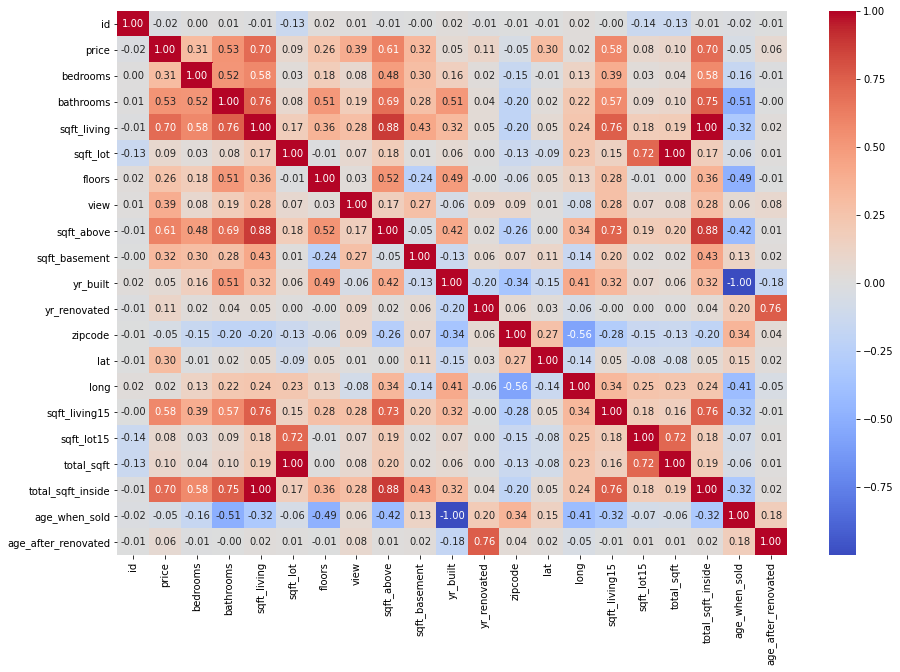

In [1089]:
fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(corr_columns, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

# 5. Dummy Variables

Categorical variables need to be transformed which I created dummy variables for each of the categorical columns. I first created a separate dataframe for the dummies and then concatenated with the original dataset.

In [1025]:
# reminder of the data types
numerical = ['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'view', 'sqft_above', 
            'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 
             'total_sqft', 'total_sqft_inside', 'age_when_sold', 'age_after_renovated']
categorical = ['waterfront', 'condition', 'grade', 'grade_binned',
               'quarter_sold', 'year_sold', 'city', 'decade_built']

In [1026]:
# create dummies into a single dataframe
# drop_first is to avoid the dummy variable trap of multicollinearity
    # you can perfectly predict what one variable will be using some combination of the other variables
dummy_data = pd.get_dummies(data[categorical],prefix=categorical,drop_first=True)

In [1027]:
dummy_data.shape

(19087, 56)

In [1028]:
dummy_data.head()

,waterfront_1.0,condition_2,condition_3,condition_4,condition_5,grade_4,grade_5,grade_6,grade_7,grade_8,...,decade_built_1920,decade_built_1930,decade_built_1940,decade_built_1950,decade_built_1960,decade_built_1970,decade_built_1980,decade_built_1990,decade_built_2000,decade_built_2010
0,0,0,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0


In [1029]:
# combine dummy data with original dataframe
data = pd.concat([data,dummy_data],axis=1)

In [1030]:
# drop categorical columns since we created the dummy variables
data = data.drop(columns=['waterfront', 'condition', 'grade', 'grade_binned',
               'quarter_sold', 'year_sold', 'city', 'decade_built'])

In [1031]:
data.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,sqft_above,sqft_basement,...,decade_built_1920,decade_built_1930,decade_built_1940,decade_built_1950,decade_built_1960,decade_built_1970,decade_built_1980,decade_built_1990,decade_built_2000,decade_built_2010
0,6414100192,538000.0,3,2.25,2570,7242,2.0,0.0,2170,400.0,...,0,0,0,1,0,0,0,0,0,0
1,8820901275,571000.0,4,2.00,2750,7807,1.5,0.0,2250,500.0,...,0,0,0,0,0,0,0,0,0,0
2,1133000671,315000.0,3,1.00,960,6634,1.0,0.0,960,0.0,...,0,0,0,1,0,0,0,0,0,0
3,3992700335,382500.0,2,1.00,1190,4440,1.0,0.0,1190,0.0,...,0,0,0,0,0,0,1,0,0,0
4,6414100671,425000.0,3,1.75,2500,6840,1.0,0.0,1300,1200.0,...,0,0,0,1,0,0,0,0,0,0


# 6. Second Model

**Changes compared to first Preliminary Model**
    * Added Feature Engineering
    * Removed Outliers
    * Convert columns to Categorical
    * Dummy Variables

In [1032]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19087 entries, 0 to 19086
Data columns (total 77 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   19087 non-null  int64  
 1   price                19087 non-null  float64
 2   bedrooms             19087 non-null  int64  
 3   bathrooms            19087 non-null  float64
 4   sqft_living          19087 non-null  int64  
 5   sqft_lot             19087 non-null  int64  
 6   floors               19087 non-null  float64
 7   view                 19087 non-null  float64
 8   sqft_above           19087 non-null  int64  
 9   sqft_basement        19087 non-null  float64
 10  yr_built             19087 non-null  int64  
 11  yr_renovated         19087 non-null  float64
 12  zipcode              19087 non-null  int64  
 13  lat                  19087 non-null  float64
 14  long                 19087 non-null  float64
 15  sqft_living15        19087 non-null 

In [1034]:
import statsmodels.api as sm

y = data['price']
# Take out price, objects, and columns with null values
x = data.drop(['price'], axis=1)
linreg = sm.OLS(y, x).fit()
linreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     997.7
Date:                Wed, 15 Jul 2020   Prob (F-statistic):               0.00
Time:                        13:43:41   Log-Likelihood:            -2.5721e+05
No. Observations:               19087   AIC:                         5.146e+05
Df Residuals:                   19016   BIC:                         5.151e+05
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
id                  -1.318e-06   4.47e-07     -2.946      0.003    -2.2e-06   -4.41e-07
bedrooms            -1.839e+04   1804.606    -10.190      0.000   -2.19e+04   -1.49e+04
bathrooms            3.318e+04   3070.005     10.809      0.000    2.72e+04    3.92e+04
sqft_living            68.1739     10.817      6.303      0.000      46.972      89.375
sqft_lot              -34.1207      5.408     -6.309      0.000     -44.722     -23.520
floors              -3772.4985   3826.808     -0.986      0.324   -1.13e+04    3728.385
view                  4.47e+04   1992.158     22.440      0.000    4.08e+04    4.86e+04
sqft_above             23.5638      5.832      4.041      0.000      12.133      34.994
sqft_basement           0.7707      5.641      0.137      0.891     -10.286      11.827
yr_built             2.474e+04   4083.437      6.058      0.000    1.67e+04    3.27e+04
yr_renovated           62.5618      5.585     11.201      0.000      51.614      73.510
zipcode             -1186.9487     68.478    -17.333      0.000   -1321.173   -1052.725
lat                  5.232e+05   2.07e+04     25.303      0.000    4.83e+05    5.64e+05
long                -3.407e+05   3.06e+04    -11.118      0.000   -4.01e+05   -2.81e+05
sqft_living15          23.1815      3.283      7.061      0.000      16.746      29.617
sqft_lot15             -0.1489      0.069     -2.171      0.030      -0.283      -0.014
total_sqft             34.3105      5.408      6.344      0.000      23.710      44.911
total_sqft_inside      24.3387     10.685      2.278      0.023       3.395      45.283
age_when_sold        2.612e+04   4102.370      6.368      0.000    1.81e+04    3.42e+04
age_after_renovated -3743.8456    435.191     -8.603      0.000   -4596.858   -2890.833
waterfront_1.0       6.376e+05    1.6e+04     39.843      0.000    6.06e+05    6.69e+05
condition_2           4.41e+04   3.82e+04      1.154      0.248   -3.08e+04    1.19e+05
condition_3           5.31e+04   3.56e+04      1.491      0.136   -1.67e+04    1.23e+05
condition_4          8.336e+04   3.56e+04      2.339      0.019    1.35e+04    1.53e+05
condition_5          1.296e+05   3.58e+04      3.616      0.000    5.94e+04       2e+05
grade_4             -6.602e+04   1.77e+05     -0.374      0.709   -4.12e+05     2.8e+05
grade_5             -8.867e+04   1.74e+05     -0.511      0.610   -4.29e+05    2.52e+05
grade_6             -5.102e+04   4.34e+04     -1.175      0.240   -1.36e+05    3.41e+04
grade_7             -6469.6906   4.34e+04     -0.149      0.881   -9.14e+04    7.85e+04
grade_8              3.817e+04   4.34e+04      0.879      0.380    -4.7e+04    1.23e+05
grade_9             -9.312e+04   4.35e+04     -2.142      0.032   -1.78e+05   -7906.973
grade_10              5.28e+04   4.36e+04      1.211      0.226   -3.27e+04    1.38e+05
gra

### Linearity Assumption

We want to check if each predictor and the target variables are both linear with each other.

In [444]:
for i, col in enumerate(data.columns):
    print(col)
#     plt.figure()
#     plt.ticklabel_format(useOffset=False, style='plain')
#     sns.distplot(data[col])
    

id
date
price
bedrooms
bathrooms
sqft_living
sqft_lot
floors
waterfront
view
condition
grade
sqft_above
sqft_basement
yr_built
yr_renovated
zipcode
lat
long
sqft_living15
sqft_lot15
total_sqft
total_sqft_inside
month_sold
year_sold
age_when_sold
city
decade_built


In [422]:
data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'grade_binned',
       'total_sqft', 'total_sqft_inside', 'quarter_sold', 'year_sold',
       'age_when_sold', 'age_after_renovated', 'city', 'decade_built'],
      dtype='object')

In [424]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_lot15,grade_binned,total_sqft,total_sqft_inside,quarter_sold,year_sold,age_when_sold,age_after_renovated,city,decade_built
0,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7639,Fair,9812,2570.0,4,2014,63,23.0,Seattle,1950
1,8820901275,6/10/2014,571000.0,4,2.00,2750,7807,1.5,0.0,0.0,...,7807,Fair,10557,2750.0,2,2014,98,-1.0,Seattle,1910
2,1133000671,6/2/2014,315000.0,3,1.00,960,6634,1.0,0.0,0.0,...,7203,Fair,7594,960.0,2,2014,62,-1.0,Seattle,1950
3,3992700335,7/7/2014,382500.0,2,1.00,1190,4440,1.0,0.0,0.0,...,5715,Fair,5630,1190.0,3,2014,33,-1.0,Seattle,1980
4,6414100671,9/9/2014,425000.0,3,1.75,2500,6840,1.0,0.0,0.0,...,8691,Fair,9340,2500.0,3,2014,57,-1.0,Seattle,1950


In [446]:
# sqft_lot, floors, view, sqft_basement, yr_built, 
# yr_renovated, zipcode, sqft_lot15, yr_sold, age_when_sold, total_sqft, and last_updated.

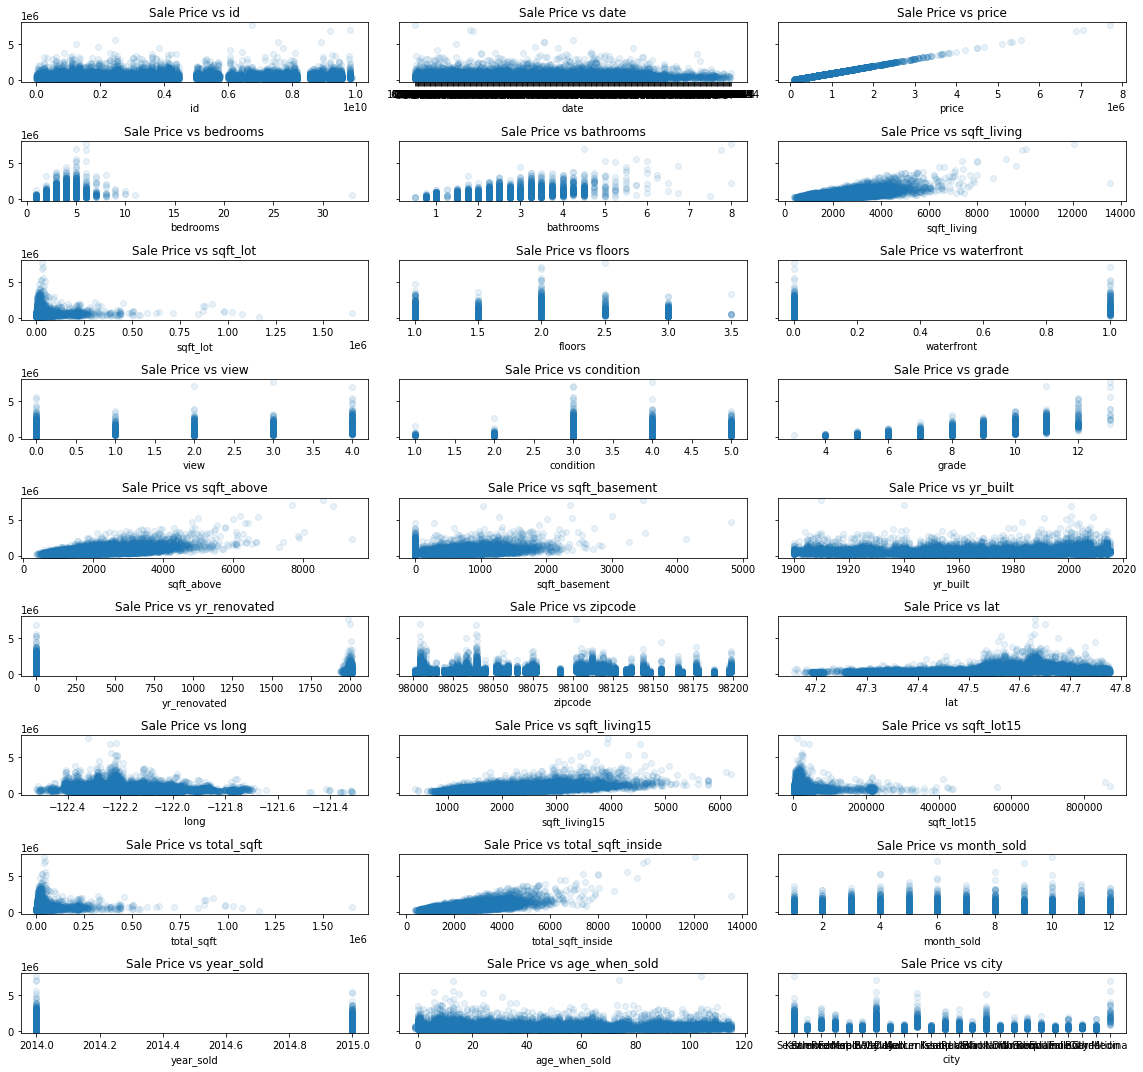

In [447]:
fig, axes = plt.subplots(nrows=9, ncols=3, figsize=(16,15), sharey=True)

for ax, column in zip(axes.flatten(), data.columns):
    ax.scatter(data[column], data['price'], label=column, alpha=.1)
    ax.set_title(f'Sale Price vs {column}')
    ax.set_xlabel(column)
#     ax.set_ylabel('Sale Price in $100,000')

fig.tight_layout()

### Remove Outliers

In [448]:
feats = data.columns
feats

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'total_sqft',
       'total_sqft_inside', 'month_sold', 'year_sold', 'age_when_sold', 'city',
       'decade_built'],
      dtype='object')

In [449]:
corr = data[feats].corr()
corr

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,sqft_above,sqft_basement,yr_renovated,lat,long,sqft_living15,sqft_lot15,total_sqft,total_sqft_inside,year_sold,age_when_sold
id,1.000000,-0.018450,0.000691,0.004343,-0.013451,-0.132648,0.018139,0.011109,-0.011794,-0.004863,-0.010857,-0.002766,0.019336,-0.003883,-0.139429,-0.132408,-0.012979,0.010077,-0.021009
price,-0.018450,1.000000,0.309640,0.525215,0.701295,0.088789,0.254972,0.392787,0.604424,0.321264,0.118278,0.306439,0.019826,0.583792,0.082045,0.103883,0.699647,0.001385,-0.050985
bedrooms,0.000691,0.309640,1.000000,0.515383,0.579069,0.032490,0.177734,0.078353,0.480242,0.297093,0.017470,-0.011266,0.132439,0.394949,0.030570,0.045118,0.575954,-0.010479,-0.155392
bathrooms,0.004343,0.525215,0.515383,1.000000,0.755522,0.087779,0.501803,0.184949,0.686328,0.278140,0.047686,0.023143,0.223808,0.569453,0.087760,0.104072,0.752916,-0.028630,-0.506657
sqft_living,-0.013451,0.701295,0.579069,0.755522,1.000000,0.172586,0.352868,0.280839,0.876533,0.427998,0.050851,0.050739,0.240212,0.756186,0.183837,0.193924,0.996459,-0.030793,-0.317104
sqft_lot,-0.132648,0.088789,0.032490,0.087779,0.172586,1.000000,-0.005561,0.075360,0.183210,0.014839,0.004991,-0.085822,0.230265,0.143805,0.717743,0.999764,0.172508,0.005305,-0.052222
floors,0.018139,0.254972,0.177734,0.501803,0.352868,-0.005561,1.000000,0.027175,0.522751,-0.242151,0.003141,0.048900,0.124812,0.279071,-0.011367,0.002236,0.355847,-0.024178,-0.489270
view,0.011109,0.392787,0.078353,0.184949,0.280839,0.075360,0.027175,1.000000,0.165289,0.270104,0.089982,0.005835,-0.079019,0.277555,0.073381,0.081244,0.278689,0.000496,0.056173
sqft_above,-0.011794,0.604424,0.480242,0.686328,0.876533,0.183210,0.522751,0.165289,1.000000,-0.051707,0.020078,-0.002040,0.344161,0.731887,0.194445,0.201784,0.877978,-0.025599,-0.423341
sqft_basement,-0.004863,0.321264,0.297093,0.278140,0.427998,0.014839,-0.242151,0.270104,-0.051707,1.000000,0.065624,0.108524,-0.143459,0.198127,0.015870,0.024210,0.432663,-0.015257,0.131407


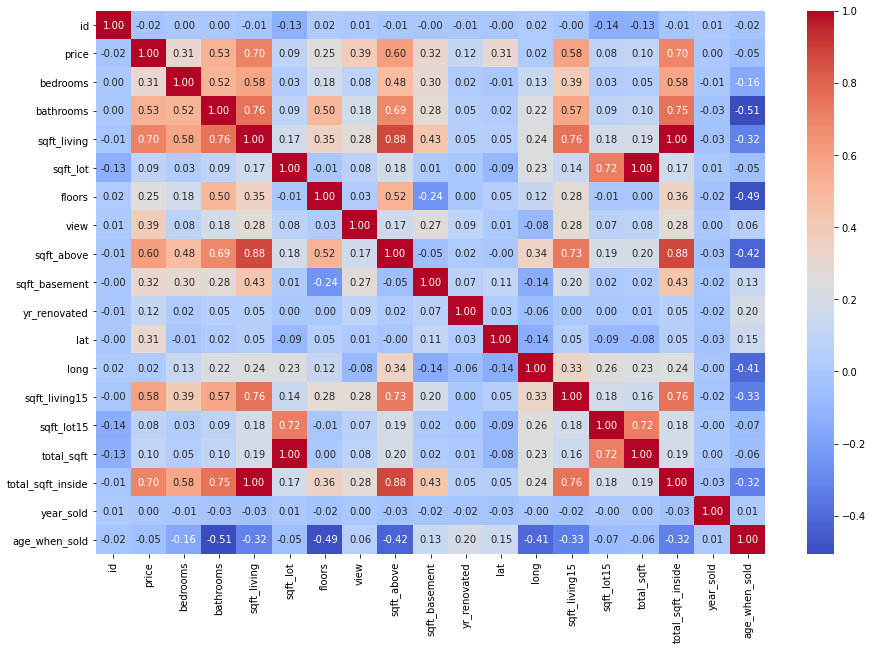

In [450]:
fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.show()